In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests, csv
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.experimental import completer
from shapely.geometry import Point, Polygon

## Data Sources
Census_total_jobs = https://data.census.gov/cedsci/table?q=United%20States&tid=ACSDP5Y2019.DP05
Lodes_crosswalk = https://lehd.ces.census.gov/data/#lodes
Demand responsive providers = https://docs.google.com/spreadsheets/d/12cu91BcAuqmeFe_Xfie5UJlKClBjbNwFNYeXC8JcM3A/edit#gid=0

### Base map for all census tracts
Census_tracts = https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html



In [88]:
census_total_jobs = pd.read_csv("calitp_acs5_tracts.csv")
#transit = pd.read_csv("Demand Response - Geography - Sheet1.csv")

census_tracts = geopandas.read_file('census_tracts/tl_2020_06_tract10.shp')
city_tracts = geopandas.read_file('california_cities/bx729wr3020.shp')

In [3]:
census_tracts.columns = census_tracts.columns.str.replace('GEOID10', 'GEOID')
census_tracts['GEOID'] = census_tracts['GEOID'].astype(int)
census_tracts_data = pd.merge(census_total_jobs, census_tracts, on="GEOID", how = 'inner')

In [ ]:
print(census_tracts)

# What is the number of transit services which have demand-responsive transit?

In [4]:
has_demand_responsive = transit.Modes.str.contains("DR",  na = False)
transit['has_demand_responsive'] = has_demand_responsive
transit.has_demand_responsive.value_counts()

True     201
False    199
Name: has_demand_responsive, dtype: int64

## 201 out of 300 have demand responsive

# What is the Percent of California( by area, population, employment) not served by fixed-route transit service?

### What is the percent of california served by fixed-route transit service 

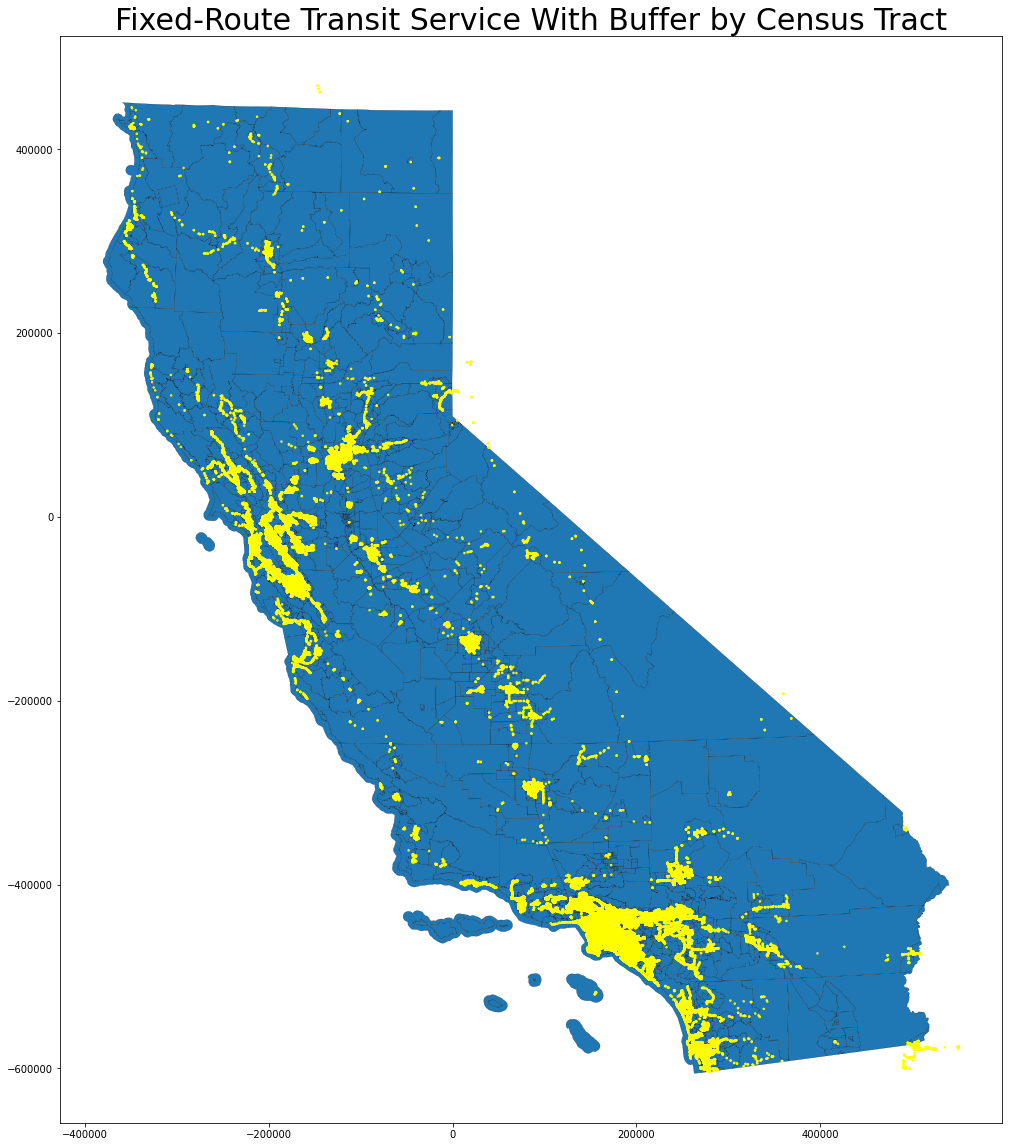

In [5]:
tbl_stop_info = (
    tbl.gtfs_schedule.stops()
    >> filter(_.calitp_itp_id != 284)
    >> select(_,_.stop_lon, _.stop_lat)
    #filter out calitp 284 because have no stop lat/long
    >> collect()
)

gdf_stops = geopandas.GeoDataFrame(tbl_stop_info, geometry=geopandas.points_from_xy(tbl_stop_info.stop_lon,tbl_stop_info.stop_lat), crs = "epsg:4326")
gdf_stops_utm = gdf_stops.to_crs(epsg=3310)
census_tracts_utm = census_tracts['geometry'].to_crs(epsg=3310)

gdf_stops_buffer = gdf_stops_utm.geometry.buffer(805)

ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_buffer.plot(ax=ax, color="none", edgecolor="yellow")


plt.title('Fixed-Route Transit Service With Buffer by Census Tract', fontsize = 30)
plt.show()

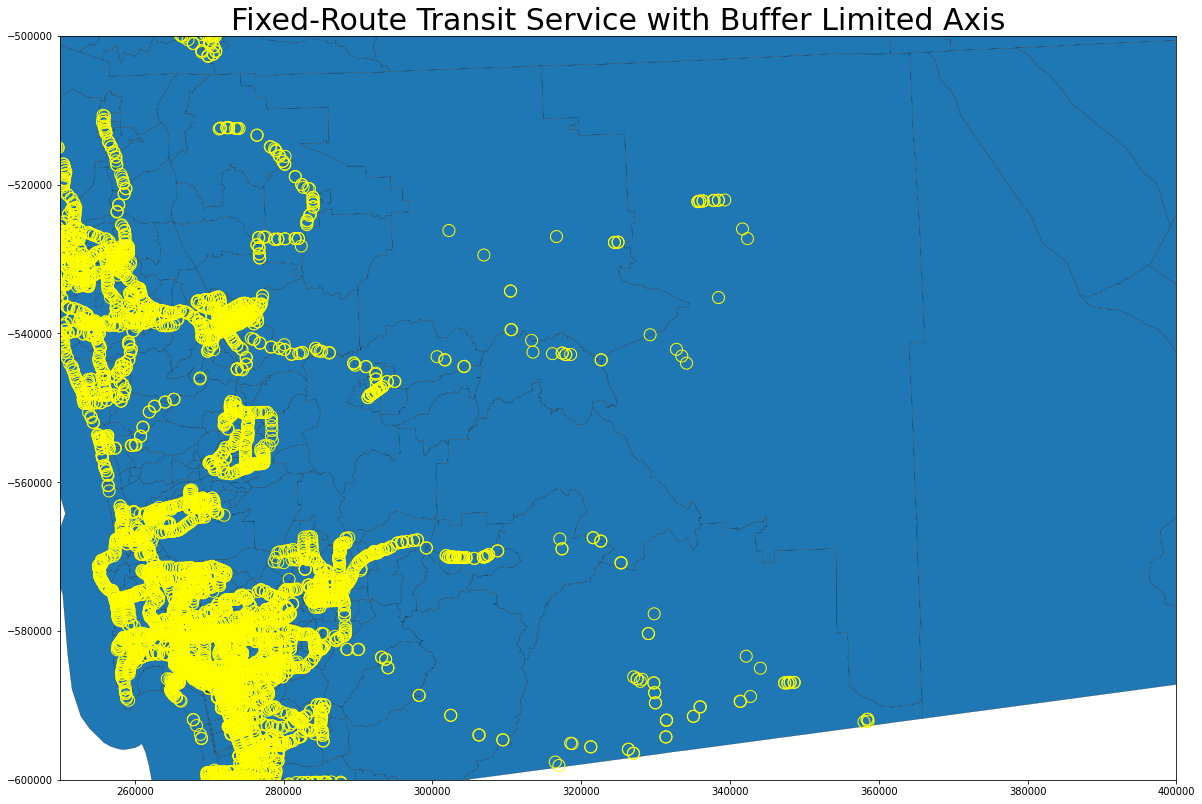

In [91]:
ax = census_tracts_utm.plot(edgecolor="black", linewidth=0.2, figsize=(20,20))
gdf_stops_buffer.plot(ax=ax, color="none", edgecolor="yellow")
plt.axis([250000,400000,-600000,-500000])
plt.title('Fixed-Route Transit Service with Buffer Limited Axis', fontsize = 30)
plt.show()

Calculates the area of intersection between the buffer and each census tract, divides the intersection area by the census tract area to calculate the fraction of the census tract area contained in the intersection, and then multiplies this decimal number by the census tract population to estimate the number of people who live within the specified distance from the stop. The code also adds all of these calculated geometries and values as columns in a new GeoDataFrame named merged.

### Calculation of total area via unary_union

In [7]:
#calculation of area by using geopandas unary_method to combine them into a single multipolygon
gdf_buffer_union = gdf_stops_buffer.unary_union
gdf_ca_union = census_tracts_utm.unary_union
print(gdf_buffer_union)
multi_polygon_buffer = gdf_buffer_union.area
multi_polygon_total = gdf_ca_union.area
print((multi_polygon_buffer/multi_polygon_total)*100)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Areas that are within .5 miles of fixed route transit make up 4.16% of total california

This calculation assumes the population is evenly distributed across the census tract, which isn’t necessarily true, so the result is only an approximation. At the same time, we’re using census tracts instead of counties for this calculation because, since their geographic areas are smaller, 
the error in this assumption shouldn’t be as great as it would be with counties.

In [40]:
## sandbox
census_tracts_gdf = geopandas.GeoDataFrame(census_tracts_data[:500])
census_tracts_gdf_crs = census_tracts_gdf.to_crs(epsg=3310)

overlap = census_tracts_gdf_crs['geometry'].intersection(gdf_buffer_union, align=False)
overlap.name = 'census_overlap'
merged = census_tracts_gdf_crs.join(overlap)
merged['tract_area'] = merged.geometry.area
merged['buffer_area'] = gdf_stops_buffer.area
merged['pct_overlap'] = merged['buffer_area']/merged['tract_area']
merged['affected_pop'] = ((merged['pct_overlap']/100) * merged['ttl_population'])
merged['affected_jobs'] = (merged['pct_overlap']/100) * merged['ttl_jobs']

In [41]:
merged_results = merged[['GEOID','NAME', 'ttl_jobs', 'ttl_population', 'tract_area', 'buffer_area', 'pct_overlap', 'affected_pop', 'affected_jobs']]
merged_results

,GEOID,NAME,ttl_jobs,ttl_population,tract_area,buffer_area,pct_overlap,affected_pop,affected_jobs
0,6001400100,"Census Tract 4001, Alameda County, California",106528.0,3120,6.935162e+06,2.032562e+06,0.293081,9.144116,312.212954
1,6001400200,"Census Tract 4002, Alameda County, California",99821.0,2007,5.937415e+05,2.032562e+06,3.423311,68.705849,3417.183146
2,6001400300,"Census Tract 4003, Alameda County, California",78089.0,5051,1.105847e+06,2.032562e+06,1.838013,92.838026,1435.285809
3,6001400400,"Census Tract 4004, Alameda County, California",73977.0,4007,7.040825e+05,2.032562e+06,2.886823,115.675005,2135.585195
4,6001400500,"Census Tract 4005, Alameda County, California",54533.0,4124,5.896393e+05,2.032562e+06,3.447128,142.159542,1879.822097
...,...,...,...,...,...,...,...,...,...
495,6013322000,"Census Tract 3220, Contra Costa County, Califo...",73388.0,6250,4.393116e+06,2.032562e+06,0.462670,28.916860,339.544081
496,6013323000,"Census Tract 3230, Contra Costa County, Califo...",75671.0,4476,1.918934e+06,2.032562e+06,1.059214,47.410417,801.517792
497,6013324001,"Census Tract 3240.01, Contra Costa County, Cal...",72289.0,5480,1.537170e+06,2.032562e+06,1.322275,72.460690,955.859634
498,6013324002,"Census Tract 3240.02, Contra Costa County, Cal...",60573.0,5247,2.008441e+06,2.032562e+06,1.012010,53.100153,613.004678


In [ ]:
## calculation of area by census tract using all census tracts
census_tracts_gdf = geopandas.GeoDataFrame(census_tracts_data)
census_tracts_gdf_crs = census_tracts_gdf.to_crs(epsg=3310)

overlap = census_tracts_gdf_crs['geometry'].intersection(gdf_buffer_union, align=False)
overlap.name = 'census_overlap'
merged = census_tracts_gdf_crs.join(overlap)
merged['tract_area'] = merged.geometry.area
merged['buffer_area'] = gdf_stops_buffer.area
merged['pct_overlap'] = merged['buffer_area']/merged['tract_area']
merged['affected_pop'] = round(merged['pct_overlap'] * merged['ttl_population'])
merged['affected_jobs'] = merged['pct_overlap'] * merged['ttl_jobs'] 

# What is the percent of California served by demand-responsive transit?

In [94]:
dr_transit = pd.read_csv("gtfs_city_only_tf.csv")
dr_transit_overview = pd.read_csv('Primary List of California Transit Providers - Overview.csv')
dr_transit_info = dr_transit_overview[['Transit Provider', 'City', 'County']]

dr_transit_data = pd.merge(dr_transit, dr_transit_info, on="Transit Provider", how = 'inner')
dr_transit_city = dr_transit_data.loc[dr_transit_data['city only'] == True]


# What is the total ridership of demand-responsive transit services?

In [ ]:
ntd_stats = pd.read_csv("Primary List of California Transit Providers - NTD Stats.csv")
ntd_stats_df = pd.DataFrame(ntd_stats)
ntd_stats_df['UPT_DR'] = ntd_stats_df['UPT_DR'].str.replace(',', '').astype(float)
total = ntd_stats_df['UPT_DR'].sum()

## Total ridership of demand-responsive transit services for California is 13,305,747 